### Logistička regresija

Vrijeme je da se upoznamo s jednim od najpoznatijih modela u strojnom učenju. Protivno nazivu logistička regresija je klasifikacijski algoritam te on uopće nema veze s regresijom. No krenimo redom. 

Problem klasifikacije je sljedeći. Za neki podatak $x$ trebamo predvidjeti kojoj klasi $y$ on pripada. Glavna razlike između regresije i klasifikacije je ta da ne postoji uređaj nad klasama. To jest za dvije oznake u regresijskom problemu, možemo reći koja je veća, a koja je manja. Dok kod klasifikacije su klase neki entiteti (primjerice pas ili mačka), te ne možemo reći je li neka klasa veća od neke druge. 

Za početak ćemo se baviti samo binarnom klasifikacijom, to jest imati ćemo samo dvije klase. Te klase ćemo u pravilu označavati s $0$ i $1$ ili s $-1$ i $1$. Često ćemo klasu s oznakom $1$ zvati *pozitivnom*, a klasu s oznakom $0$ ili $-1$ *negativnom*.

Uz ovako definirane oznake postavlja se pitanje zašto jednostavno ne koristit model linearne regresije te naučiti model da pozitivnim primjerima da oznaku $1$, a negativnima $0$. Iako se na prvu ovo čini kao dobra ideja problem je sljedeći. Zamislite da radimo klasifikaciju između mačke i slona te da je slon pozitivna klasa. Težina za značajku težine bi bila pozitivna. Intuitivno što je ta životnija teža mi smo sigurniji da je riječ o slonu. No ako je riječ o stvarno velikom slonu, mi ćemo "preskočiti" jedinicu, te će nam izlaz regresije primjerice biti jednak dva. No zbog kvadratnog gubitka, to će biti jednako krivao kao da smo rekli da je riječ o mački. Time odmah možemo uvidjeti da je kvadratni gubitak kriva vrsta funkcije pogreške za problem klasifikacije.

In [2]:
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.linear_model import LinearRegression, LogisticRegression

def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);



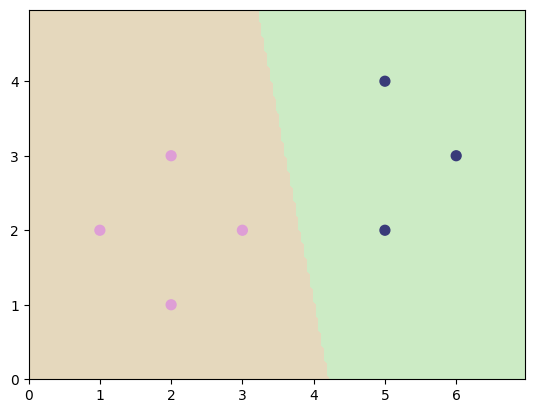

In [3]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

# Vaš kôd ovdje

reg = LinearRegression().fit(seven_X, seven_y)
h = lambda x: reg.predict(x) >= 0.5

plot_2d_clf_problem(seven_X, seven_y, h)


[ 0.67600701  0.98423818  1.03152364  0.62872154  0.22591944  0.53415061
  0.17863398 -0.2591944 ]


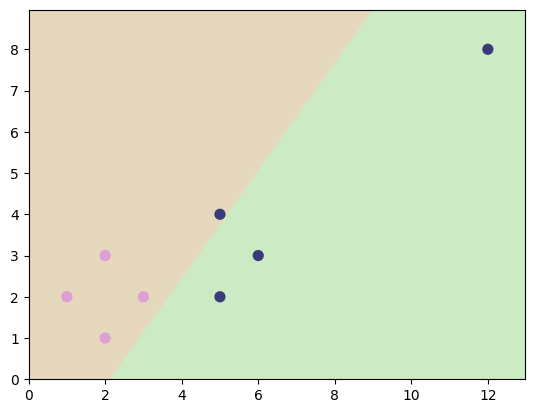

In [4]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

clf = LinearRegression().fit(outlier_X, outlier_y)
y_pred = clf.predict(outlier_X)
h = lambda x: clf.predict(x) >= 0.5

plot_2d_clf_problem(outlier_X, outlier_y, h)
print(y_pred)

Kako bi smo radili klasifikaciju nužno je promijeniti funkciju pogreške, ali i sam model. Naime izlaz ovakvog linearnog modela je neograničen. Teoretski, izlaz je ograničen samo amplitudom značajki podataka na ulazu. Idealno bi smo htjeli ograničiti izlaz modela na interval $[0, 1]$. Naime u tom slučaju izlaz modela možemo interpetirati kao *vjerojatnost*. Konkretno to je vjerojatnost da podatak pripada pozitivnoj to jest klasi s labelom $1$. Formalno:
$$
h(\bold{x}; \bold{\theta}) = P(y = 1 | \bold{x}). 
$$
To jest želimo da izlaz modela definira uvjetnu vjerojatnost oznaka. Uvjetna vjerojatnost je vjerojatnost nekog događaja $A$, ako znamo da se dogodio događaj $B$. U slučaju strojnog učenja podatak $\bold{x}$ upravo je događaj $A$, a klasa koju ćemo dodijeliti tom podatku je $B$. Vratimo se kratko na primjer slonova i mačaka. Naime kilaža životnije, obujam i visina su značajke to jest elemnti vektora $\bold{x}$. Mi te značajke možemo opaziti i one značajno mijenjaju (uvjetnu) vjerojatnost oznake koju ćemo pridjeliti toj životniji.  

Kako osigurati da je izlaz funkcije ograničen u traženi interval? Koristeći funkcije gnječilice (eng. *squashing functions*) kojima ćemo "omotati" izlaz običnog linearnog modela. Najpoznatija takva funkcija je sigmoida ili *logistička* funkcija koja je dana s: 

$$
\sigma(x) = \frac{1}{1+e^{-x}}
$$

Krenuli smo od modela linearne regresije, identificirali smo njegove glavne nedostatke te uz ovu promjenu došli do novog skupa hipoteza modela za klasifikaciju. Formalno skup hipoteza indeksiran parametrima $\bold{\theta}$ ili češće označenih s $\bold{w}$ je:

$$
h_{\bold{w}}(\bold{x}) = \{ \sigma(\bold{w}^T \bold{x}) \}
$$

Model smo "popravili", još je potrebno obračunati se s funkcijom pogreške. Pošto izlaz našeg modela modelira uvjetnu vjerojatnost, želimo da se uvjetna vjerojatnost modela minimalno razlikuje od stvarne uvjetne vjerojatnosti (koju pronalazimo u podatcima). Matematička funkcija koja mjeri različitost dvije vjerojatnosne razdiobe zove se divergencija od kojih je posebno poznata [KL-divergencija](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). Mi nećemo direktno koristi tu divergenciju kao pogrešku već *unakrsnu entropiju* za koji se može pokazati da ako se minimizira, onda se minimizira i KL-divergencija. Konkretno
$$
E(\mathbf{w}|\mathcal{D}) = \frac{1}{N} \sum_{i=1}^{N} \left( - y^{(i)} \ln h(\mathbf{x}^{(i)}; \mathbf{w}) - (1 - y^{(i)}) \ln (1 - h(\mathbf{x}^{(i)}; \mathbf{w})) \right)

$$

Pogledajmo što se ovdje ustvari događa. Naime iteriramo kroz sve podatke u skupu podataka $\mathcal{D}$. Svaki podatk ima svoj vektor značajki $\bold{x}^i$ i svoju oznaku
$y^i$. U slučaju da je oznaka $y^i = 0$, izraz unutar sume svodi se na $-\ln (1 - h(\mathbf{x}^{(i)}; \mathbf{w})$. To jest znaima nas prirodni logaritam vjerojatnosti da primjer pripada negativnoj klasi (klasi s oznakom $0$). Vrijednost ovog izraza je jednaka $0$ kada je izlaz modela jednak $0$ (to jest kada je vjerojatnost da primjer ima oznaku $1$ jednaka $0$, to jest model je siguran da je oznaka primjera $0$), inače je izlaz negativan (a zbog negativnog predznaka postaje pozitivan). U slučaju da je stvarna oznaka primjera jednaka $y^i = 1$, onda bi nas zanimo logaritam vjerojatnosti da primjer pripada pozitivnoj klasi. Minimizacijom ovog zbroja osiguravamo da model pridjeljuje najvjerojatnije oznake gledano na cijelom skupu podataka, a ne samo na jednom primjeru. Pošto je funkcija pogreške prosječni gubitak, funkciju gubitka logističe regresije definiramo s:

$$
\mathcal{L}(\mathbf{w},h(\mathbf{x}^{(i)})) = - y^{(i)} \ln h(\mathbf{x}^{(i)}; \mathbf{w}) - (1 - y^{(i)}) \ln (1 - h(\mathbf{x}^{(i)}; \mathbf{w})) 

$$

Ostaje još otvoreno pitanje koji oćemo optimizacijski postupak koristiti. Zbog logaritma koji se nalazi u sumi ne postoji analitičko rješenje kao u slučaju linearne regresije. Zbog toga posežemo za poznatim iterativnim algoritmom *gradijentnim spustom*. Prije samog gradijentog spusta podsjetimo se što je gradijent. Kod funkcije jedne varijable dervacije je brzina rasta funkcije. Predznak derivacije nam govori u kojem smjeru moramo pomaknuti $x$, da bi $f(x)$ narastao. U slučaju funkcija više varijabli (poput naše funkcije pogreške) postoji više $x$-eva koje možemo pomicati, no nas zanima ona kombinacija pomaka kako bi funkcija najbrže rasla. Smjer u kojem se moramo kretati da bi ostvarili najviši rast funkcije zove se gradijent i to je vektor čije se komponentne sastoje od parcijalnih derivacija funkcije. Pošto funkciju želimo minimizirati, mi se moramo kretati u smjeru suprotnom od smjera gradijenta. 


### Gradijentni spust
___

1. Izračunaj gradijent $\nabla E(\mathbf{w})$ 

2. Pomakni se u smjeru suprotnom od gradijenta: $\mathbf{w} \leftarrow \mathbf{w} - \alpha \nabla E(\mathbf{w})$
___

Iako su formalno i skup podataka i vektor težina $\bold{w}$ parametri funkcije, skup podataka se u pravilu ne mijenja te ga shvaćamo kao konstantu. Zbog toga računamo gradijent samo po elementima vektora težina. $\alpha$ je parametar koji određuje veličinu koraka i on je u pravilu između $10^{-2}$ i $10^{-7}$ ovisno o funkciji koju optimiramo. U slučaju prevelikog koraka postupak može divergirati, a u slučaju premalog koraka konvergencija može biti jako spora. U pravilu nećemo računati gradijent pogreške (nad svim primjerima), već gradijent gubitka nad jednim primjerom te ćemo nakon svakog primjera osvježiti vektor težina. U pravilu će biti potrebno više puta proći kroz sve primjere u skupu za učenje i jedan takav prolaz nazivamo epohom. U slučaju da prolazimo primjer po primjer potrebno je između epoha promiješati primjere.

Ostaje nam još izračunati gradijent funkcije pogreške i definirali smo sve tri komponente logističke regesije.

Pošto je derivacija (a i računanje gradijenta) linearan operator derivacija sume je suma derviacija pa vrijedi sljedeće:

$$
\nabla_{\mathbf{w}} E(\mathbf{w}|\mathcal{D}) = \frac{1}{N} \sum_{i=1}^{N} \nabla_{\mathbf{w}} L \left( y^{(i)}, h(\mathbf{x}^{(i)}; \mathbf{w}) \right)
$$
Potreban nam je gradijent gubitka koji je jednak:
 $$
 \nabla_{\mathbf{w}} L(y, h(\mathbf{x})) = \left( -\frac{y}{h(\mathbf{x})} + \frac{1 - y}{1 - h(\mathbf{x})} \right) h(\mathbf{x})(1 - h(\mathbf{x})) \phi(\mathbf{x})

 $$
 $$
 = (h(\mathbf{x}) - y) \phi(\mathbf{x})

 $$

Sada imamo sve potrebne elemente za implementaciju algoritma logističke regresije


Pogledajmo kako bi takav model koristili u praksi:

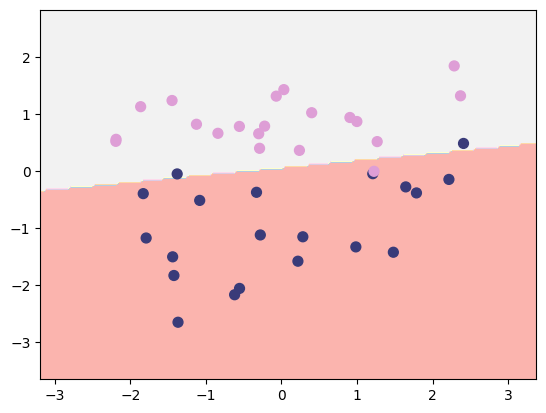

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

X,y = make_classification(n_samples=40, n_redundant=0, n_features=2)

clf = LogisticRegression()
clf.fit(X,y)

plot_2d_clf_problem(X, y, lambda x: clf.predict(x))

Vidimo da se sama primjena modela nimalo ne razlikuje od modela linearne regresije. Naime postupak je ponovno isti. Stvorimo objekt model logističke regresije, kojeg potom učimo pomoću metode `fit` nad podatcima. Nakon toga model možemo koristiti za daljnje zaključivanje.

Jedan od glavnih nedostataka logističke regresije je što može razdvojiti samo *linearno odvojive podatke*, to jest podatke koje možemo odvojiti jednim pravcem. Pogledajmo bolji primjer:

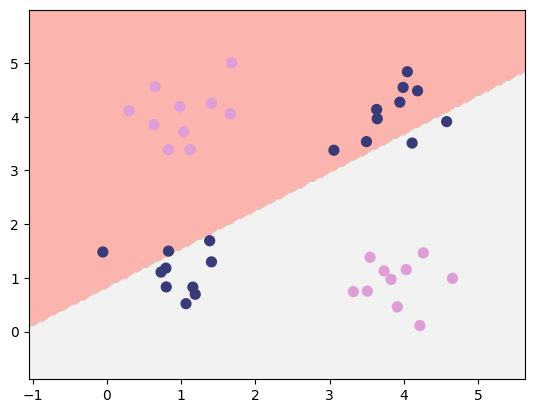

In [8]:
def make_quad(n_per_quad=10, centers=None, center_labels=None, cov_matrix=None):
    if centers is None:
        centers = np.array([
            [1,1],
            [1,4],
            [4,4],
            [4,1]
        ])

    if center_labels is None:
        center_labels = [0,1,0,1]


    if cov_matrix is None:
        cov_matrix = [[0.2, 0], [0, 0.2]]

    X, y = [], []
    for center, label in zip(centers, center_labels):
        points = np.random.multivariate_normal(mean=center,cov=cov_matrix, size=n_per_quad)
        X.append(points)
        y.extend([label] * n_per_quad)

    X = np.vstack(X)
    y = np.array(y)

    return X,y  


X, y = make_quad()
clf = LogisticRegression()
clf.fit(X,y)

plot_2d_clf_problem(X, y, lambda x: clf.predict(x))

Očito je ovakav nedostatak prilično ozbiljna stvar. Srećom, problem je moguće riješiti pomoću polinomijalnog preslikavanja na potpuno isti način kao i kod linearne regresije. Također, stupanj potrebnog preslikavanja nam neće biti unaprijed poznat, ali će se ponašati kao hiperparametar. Što je preslkavanje višeg stupnja, to će naš model imati veći kapacitet.

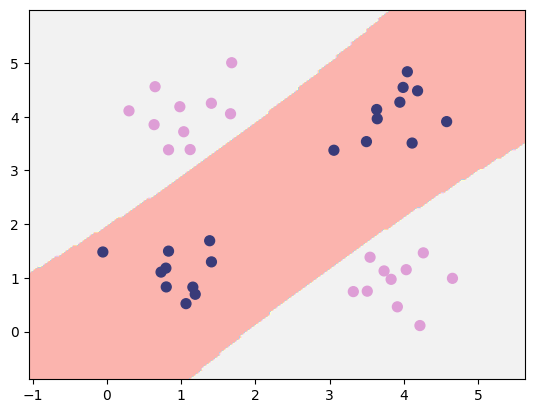

In [9]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
phi = poly.fit_transform(X)
clf = LogisticRegression()
clf.fit(phi,y)

plot_2d_clf_problem(X, y, lambda x: clf.predict(poly.transform(x)))

Rezultat je izvrstan. Ne samo da naša granica sada može biti nelinearna, ona se može sastojati od više linija. Postavlja se pitanje kako otkriti najbolji stupanj preslikavnja. Što je uopće najbolji stupanj preslikavnja? To je onaj stupanj za koji naš model ima dovoljan kapacitet da nauči razlikovati klase, ali nedovoljno velik da počne učiti šum. Odgovor na ovaj problem nam ponovno daje unakrsna validacija. Pogledajmo još jedan primjer

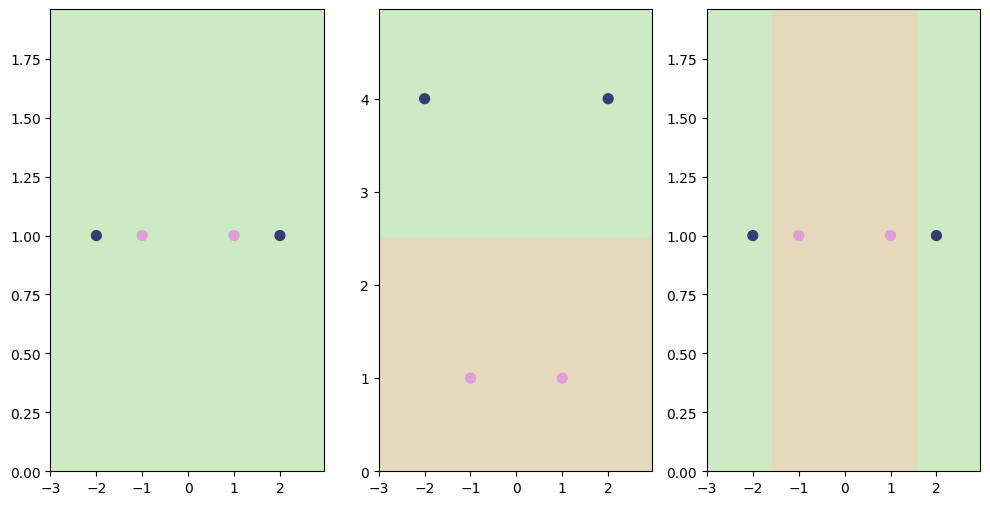

In [25]:
X = np.array([[-2,1],[-1,1],[1,1],[2,1]])
y = np.array([0,1,1,0])

clf = LogisticRegression()
clf.fit(X,y)

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plot_2d_clf_problem(X,y, lambda x: clf.predict(x) > 0.5)

X_n = X.copy()
X_n[:,1] = X[:, 0] **2
y = np.array([0,1,1,0])

clf = LogisticRegression()
clf.fit(X_n,y)

plt.subplot(1,3,2)
plot_2d_clf_problem(X_n,y, lambda x: clf.predict(x) > 0.5)

plt.subplot(1,3,3)
plot_2d_clf_problem(X,y, lambda x: clf.predict(np.column_stack((x[:,0], x[:,0]**2))) > 0.5)




Na ovom jednodimenzionalnom slučaju jasno vidimo moć nelinarnih transformacija. Naime sada smo nebitnu informaciju u drugoj značajki (konstantna je, pa ne nosi nikakvu informaciju), zamijenili s kvadratnom transformacijom druge značajke. To nam je omogućilo da jednostavno razdvojimo ove podatke što prije nismo mogli napraviti. Na drugom grafu vidimo izgled tog pravca u nelinearnom prostoru, a na trećem grafu vidimo kako taj pravac izgleda u originalnom prostoru. U originalnom prostoru taj pravac postaje nelinaran što je upravo ponašanje kakvo želimo dobiti

## Regularizacija

Kod linearno odvojivih problema, logistička regresija nikada ne konvergira (ne dolazi do kraja optimizacijskog postupka). Razlog je sljedeći, naime potšo logistička regresija želi maksimizirati izglednost (umnožak svih vjerojatnosti podataka), a podatci su linearno odvojivi (prije ili poslije preslikavanja) onda algoritam nastoji na izlazima imati samo $1.0$ ili $0.0$ kako bi se samnjio gubitak. Pošto su ti izlazi mogući samo za $\infty$ i $-\infty$, optimizacijski postupak povećava težine u nedogled. Zbog toga logistička regresija *gotvo* uvijek ima regularizaciju. U pravilu je to $L_2$ regularizacija, ali mogu se koristiti i ostale. Jačina regularizacije je također hiperparametar i optimalnu regularizaciju pronalazimo unakrsnom provjerom.

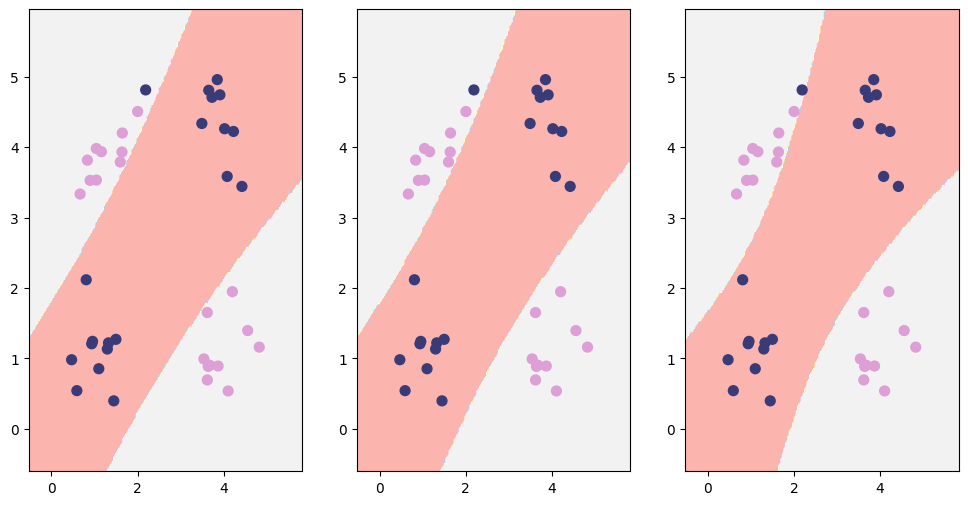

In [34]:
X, y = make_quad()
poly = PolynomialFeatures(degree=2)
phi = poly.fit_transform(X)
plt.figure(figsize=(12,6))


clf = LogisticRegression(C=0.1) # C je inverzan stupnju regularizacije !!!!!!!!!!
clf.fit(phi,y)

plt.subplot(1,3,1)
plot_2d_clf_problem(X, y , lambda x: clf.predict(poly.transform(x)))

clf = LogisticRegression(C=1) # C je inverzan stupnju regularizacije !!!!!!!!!!
clf.fit(phi,y)

plt.subplot(1,3,2)
plot_2d_clf_problem(X, y , lambda x: clf.predict(poly.transform(x)))

clf = LogisticRegression(C=10) # C je inverzan stupnju regularizacije !!!!!!!!!!
clf.fit(phi,y)

plt.subplot(1,3,3)
plot_2d_clf_problem(X, y , lambda x: clf.predict(poly.transform(x)))




Vidimo da slabija regularizacija stvara nelinearanije granice.

## Višeklasna klasifikacija

U praksi, rijetko kada postoje samo dvije klase. Zamislite da morate prepoznavati slike znamenki, tada bi postojalo 10 klasa. Slična se stvar pojavljuje kod prepoznavanja prometnih znakova, određivanja tona rečenice, prepoznavanja karcinoma i slično. Zbog toga je dobro ako naš model može raditi i sa više klasa. Kod logističke regresije to rješavamo na više načina. Jedan je korištenje shema OVO i OVR, a drugi je poopćenjem modela logističke regresije u model multinomijalne regresije. Zgodna je stvar što takve generalizacije zahtjevaju minimalne izmjene u programskom kodu. 

### OVR shema
Jedan protiv svih (*one versus all*) shema radi sljedeće. Za svaku klasu stvaramo novi model, sa svojim skupom podataka. Naime uzeti ćemo cijeli originalni skup i samo promijeniti labele. Za ciljnu klasu ćemo labele staviti na $1$, a za **SVE** ostale na $0$. Tada efektivno učimo taj model da prepoznaje pripada li nešto klasi ili ne. Ako imamo $K$ klasa tada nam je potrebno $K$ modela. Proces zaključivanja je prilično jednostavan. Jednostavno ćemo vjerovati onom modelu koji je najsigurniji (ima najveću vjerojatnost na izlazu) da primjer pripada upravo njegovoj klasi. 


### OVO shema
Jedan protiv jednog (*one versus one*) shema je malo kompliciranija. Naime umjesto da radimo model za svaku klasu, napraviti ćemo model za svaki par klasa. Skup podataka takvog modela ćemo ipak značajno promijeniti. Radi jednostavnosti pretpostavimo da smo odabrali klase $0$ i $1$. **SVE** ostale podatke iz originalnog skupa nećemo koristiti. Na taj način stvaramo modele koji odlučuju kojoj od dvije klase podatak pripada. Ako imamo $K$ klasa potrebno nam je $\frac{K(K-1)}{2}$ modela, to jest jedan za svaki par. 


### Multinomijalna logistička regresija
Ovaj pristup je najkompliciraniji, ali se u pravilu najbolje ponaša. Sada nećemo stvarati više modela, već ćemo povećati kapacitet jednog modela i malo promijeniti funkciju gnječilicu. Ideja je sljedeća, za svaku klasu, dodat ćemo vektor težina $\bold{w_i}$. Te ćemo za svaku klasu računati skalarni produkt između pripadnog vektora težina i vektora značajki $\bold{x}$. Nakon takve operacije izlaz našeg modela će biti vektor *logita*. Mi ćemo primjer klasificirati u onu klasu koja ima najveći logit. Pošto je zgodno da izlatz modela bude vjerojatnosna distribucija nad klasama, logite ćemo propustiti kroz funkciju **softmax** koja vraća stohastički vektor. Formalno će naš model izgledati ovako:

$$
\bold{W}  = \begin{bmatrix}
            \bold{w_1}^T \\
            \bold{w_2}^T \\
            \vdots \\
            \bold{w_n}^T

\end{bmatrix}
$$
$$
h_{\bold{W}}(\bold{x}) = Softmax(\bold{W}\bold{x})
$$

### Programska implementacija
Programski ova proširenja vrlo jednostavno ostvarujemo:

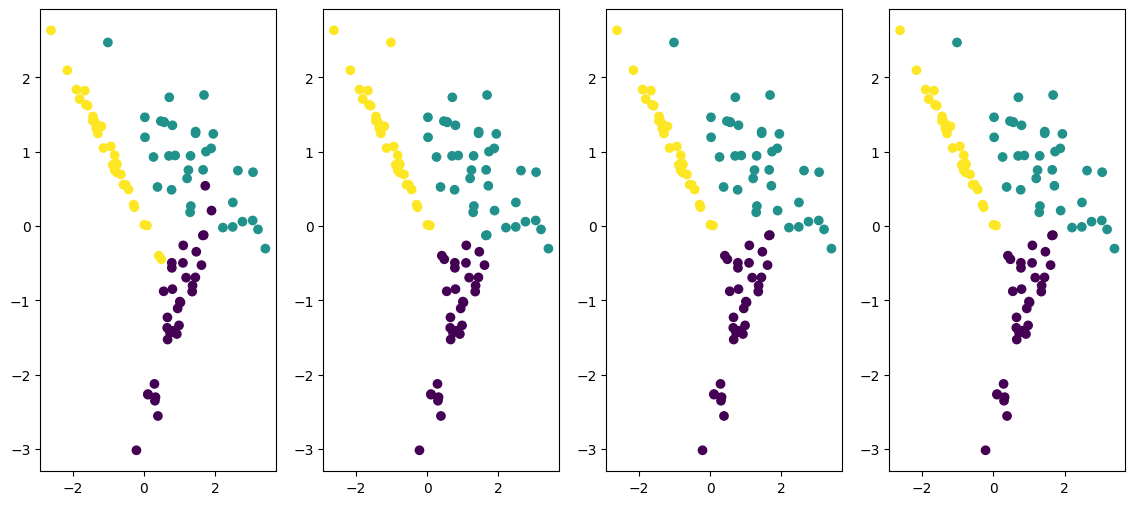

In [31]:
from sklearn.multiclass import OneVsRestClassifier,  OneVsOneClassifier

X, y = make_classification(n_classes=3, n_features=2, n_redundant=0, n_clusters_per_class=1)

plt.figure(figsize=(14,6))

plt.subplot(1,4,1)
plt.scatter(X[:,0], X[:,1], c=y)

ovr = OneVsRestClassifier(LogisticRegression())

ovr.fit(X,y)
pred = ovr.predict(X)

plt.subplot(1,4,2)


plt.scatter(X[:,0], X[:,1], c=pred)

ovo = OneVsOneClassifier(LogisticRegression())

ovo.fit(X,y)
pred = ovo.predict(X)

plt.subplot(1,4,3)
plt.scatter(X[:,0], X[:,1], c=pred)

clf = LogisticRegression()
clf.fit(X,y)
pred = clf.predict(X)

plt.subplot(1,4,4)
plt.scatter(X[:,0], X[:,1], c=pred)

